In [9]:
import numpy as np


In [2]:
pip install tkcalendar



SyntaxError: invalid syntax (218145506.py, line 1)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


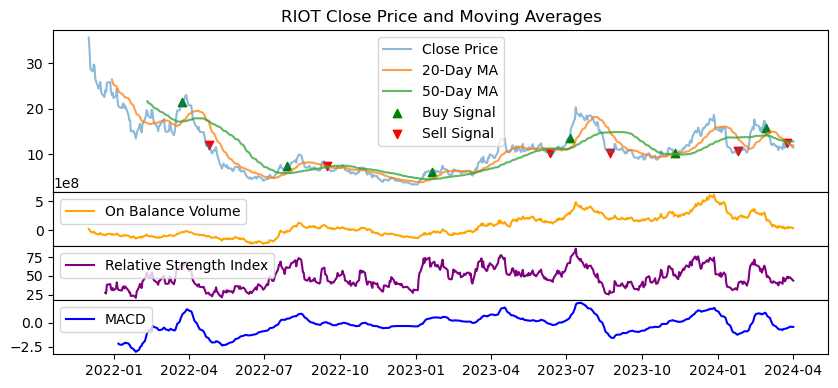

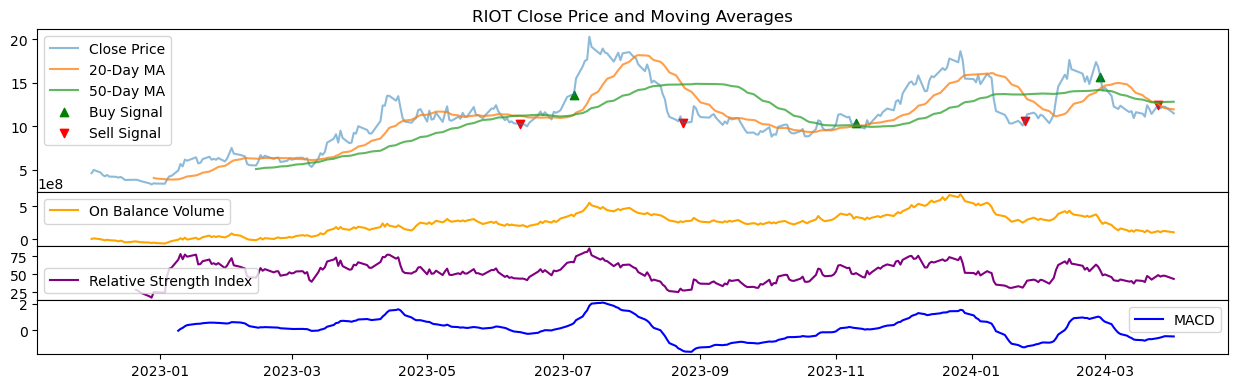

In [13]:
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox
from tkcalendar import DateEntry  # Import the DateEntry widget
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import finnhub
import requests
import pandas_ta as ta





class StockHolderApp(tk.Tk):
    def __init__(self, api_key):
         super().__init__()
         self.title('Stock Holder Interface')
         self.geometry('1000x800')
         self.finnhub_client = finnhub.Client(api_key=api_key)
         self.create_widgets()
        
        
    def fetch_symbol_info(self, keyword):
        try:
            response = self.finnhub_client.symbol_lookup(keyword)
            return response
        except Exception as e:
            print(f"Error fetching symbol info: {e}")
            return None

    def create_widgets(self):
        # Create a top frame for control widgets
        self.control_frame = ttk.Frame(self)
        self.control_frame.pack(fill=tk.X, side=tk.TOP, pady=5)

        # Stock symbol input inside the control frame
        self.stock_symbol_label = ttk.Label(self.control_frame, text='Stock Symbol:')
        self.stock_symbol_label.pack(side=tk.LEFT, padx=5)

        self.stock_symbol_entry = ttk.Entry(self.control_frame)
        self.stock_symbol_entry.pack(side=tk.LEFT, padx=5)

        # Start date picker inside the control frame
        self.start_date_label = ttk.Label(self.control_frame, text='Start Date:')
        self.start_date_label.pack(side=tk.LEFT, padx=5)

        self.start_date_entry = DateEntry(self.control_frame, width=12, background='darkblue', foreground='white', borderwidth=2)
        self.start_date_entry.pack(side=tk.LEFT, padx=5)

        # End date picker inside the control frame
        self.end_date_label = ttk.Label(self.control_frame, text='End Date:')
        self.end_date_label.pack(side=tk.LEFT, padx=5)

        self.end_date_entry = DateEntry(self.control_frame, width=12, background='darkblue', foreground='white', borderwidth=2)
        self.end_date_entry.pack(side=tk.LEFT, padx=5)

        # Plot button inside the control frame
        self.plot_button = ttk.Button(self.control_frame, text='Plot Data', command=self.plot_stock_data)
        self.plot_button.pack(side=tk.LEFT, padx=5)

        # Create and pack the 'Show Market News' button
        self.info_button = ttk.Button(self.control_frame, text='Show Market News', command=self.show_market_news)
        self.info_button.pack(side=tk.LEFT, padx=5)

        # Text widget for displaying information or news
        self.info_text_widget = tk.Text(self, height=20, width=80, wrap=tk.WORD)
        self.info_text_widget.pack(padx=10, pady=10)
        self.info_text_widget.config(state=tk.DISABLED)  # Start as read-only

        # Placeholder for the matplotlib figure
        self.figure_frame = ttk.Frame(self)
        self.figure_frame.pack(fill=tk.BOTH, expand=True)

 #       self.info_button = ttk.Button(self.control_frame, text='Show Market News', command=self.show_market_news)
 #       self.info_button.pack(side=tk.LEFT, padx=5)
        
    def fetch_market_news(self, category='general'):
        base_url = "https://finnhub.io/api/v1/news"  # Use the correct FinnHub endpoint
        params = {'category': category, 'token': 'co5iolpr01qrjq1g59egco5iolpr01qrjq1g59f0'}  # Replace 'your_api_key' with your actual FinnHub API key
        response = requests.get(base_url, params=params)

        if response.status_code == 200:
            return response.json()
        else:
            print(f"Failed to fetch news. Status code: {response.status_code}")
            return []

    def show_market_news(self):
        news_items = self.fetch_market_news()

    # Start with an empty string
        news_text = ""

        for item in news_items[:5]:  # Let's limit to the first 5 news items for brevity
            news_text += f"Headline: {item['headline']}\nSummary: {item['summary']}\nURL: {item['url']}\n\n"

    # Display the news in the Text widget
        self.info_text_widget.config(state=tk.NORMAL)
        self.info_text_widget.delete('1.0', tk.END)
        self.info_text_widget.insert(tk.END, news_text)
        self.info_text_widget.config(state=tk.DISABLED)

 
    def show_symbol_info(self, keyword):
        info = self.fetch_symbol_info(keyword)
        if info:
            # Format the response data into a readable string
            info_text = "\n".join([f"{item['description']} ({item['symbol']})" for item in info.get('result', [])])
            self.update_info_text(info_text)
        else:
            self.update_info_text("No information found or an error occurred.")

 
    def update_info_text(self, text):
        self.info_text_widget.config(state=tk.NORMAL)
        self.info_text_widget.delete('1.0', tk.END)
        self.info_text_widget.insert(tk.END, text)
        self.info_text_widget.config(state=tk.DISABLED)
    
   

        
    def plot_stock_data(self):
        # Fetch stock data
        stock_symbol = self.stock_symbol_entry.get()
        start_date = self.start_date_entry.get_date().strftime('%Y-%m-%d')  # Get the date as a string
        end_date = self.end_date_entry.get_date().strftime('%Y-%m-%d')  # Get the date as a string

        stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
        if stock_data.empty:
            messagebox.showinfo("No Data", "No data found for the given dates. Please try different dates.")
            return

        stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
        if stock_data.empty:
            messagebox.showinfo("No Data", "No data found for the given dates. Please try different dates.")
            return

        # Calculate technical indicators
        stock_data['Short_MA'] = stock_data['Close'].rolling(window=20).mean()
        stock_data['Long_MA'] = stock_data['Close'].rolling(window=50).mean()

        # Create the crossover buy and sell signals
        stock_data['Buy_Signal'] = np.where((stock_data['Short_MA'] > stock_data['Long_MA']) & 
                                            (stock_data['Short_MA'].shift(1) <= stock_data['Long_MA'].shift(1)), 
                                            stock_data['Close'], np.nan)

        stock_data['Sell_Signal'] = np.where((stock_data['Short_MA'] < stock_data['Long_MA']) & 
                                             (stock_data['Short_MA'].shift(1) >= stock_data['Long_MA'].shift(1)), 
                                             stock_data['Close'], np.nan)

        stock_data['OBV'] = ta.obv(stock_data['Close'], stock_data['Volume'])
        stock_data['RSI'] = ta.rsi(stock_data['Close'])
        stock_data['MACD'] = ta.macd(stock_data['Close'])['MACD_12_26_9']

        # Setup figure and gridspec
        fig = plt.figure(figsize=(14, 14))
        gs = gridspec.GridSpec(4, 1, height_ratios=[3, 1, 1, 1], figure=fig)

        # Close Price Chart with MA and Signals
        ax0 = fig.add_subplot(gs[0])
        ax0.plot(stock_data.index, stock_data['Close'], label='Close Price', alpha=0.5)
        ax0.plot(stock_data.index, stock_data['Short_MA'], label='20-Day MA', alpha=0.75)
        ax0.plot(stock_data.index, stock_data['Long_MA'], label='50-Day MA', alpha=0.75)
        ax0.scatter(stock_data.index, stock_data['Buy_Signal'], label='Buy Signal', marker='^', color='green', alpha=1)
        ax0.scatter(stock_data.index, stock_data['Sell_Signal'], label='Sell Signal', marker='v', color='red', alpha=1)
        ax0.set_title(f'{stock_symbol} Close Price and Moving Averages')
        ax0.legend()

        # Other Technical Indicators
        ax1 = fig.add_subplot(gs[1], sharex=ax0)
        ax1.plot(stock_data.index, stock_data['OBV'], label='On Balance Volume', color='orange')
        ax1.legend()

        ax2 = fig.add_subplot(gs[2], sharex=ax0)
        ax2.plot(stock_data.index, stock_data['RSI'], label='Relative Strength Index', color='purple')
        ax2.legend()

        ax3 = fig.add_subplot(gs[3], sharex=ax0)
        ax3.plot(stock_data.index, stock_data['MACD'], label='MACD', color='blue')
        ax3.legend()

        # Improve layout
        plt.setp(ax0.get_xticklabels(), visible=False)
        plt.setp(ax1.get_xticklabels(), visible=False)
        plt.setp(ax2.get_xticklabels(), visible=False)
        plt.subplots_adjust(hspace=0)

        # Embed the figure in the Tkinter window
        for widget in self.figure_frame.winfo_children():
            widget.destroy()
        canvas = FigureCanvasTkAgg(fig, master=self.figure_frame)
        canvas_widget = canvas.get_tk_widget()
        canvas_widget.pack(fill=tk.BOTH, expand=True)
        canvas.draw()

if __name__ == '__main__':
    api_key = "co5iolpr01qrjq1g59egco5iolpr01qrjq1g59f0"  # Make sure to replace this with your real API key
    app = StockHolderApp(api_key=api_key)
    app.mainloop()

  Obtaining dependency information for finnhub-python from https://files.pythonhosted.org/packages/80/b0/d71a0ba93c28996b02f1e74f7b9a689211092c5415bab2d3b2985df04617/finnhub_python-2.4.19-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
pip install finnhub-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
pip install ta



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29422 sha256=cce31d2b7fbbcda8db858e91d63977fd626f47a5fb8cb3afea9984ccd93b6afa
  Stored in directory: c:\users\saak0033\appdata\local\pip\cache\wheels\5f\67\4f\8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox
from tkcalendar import DateEntry
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import yfinance as yf
import pandas as pd
import numpy as np
import requests
import pandas_ta as ta

class StockHolderApp(tk.Tk):
    def __init__(self, api_key):
        super().__init__()
        self.title('Stock Holder Interface')
        self.geometry('1000x800')
        self.api_key = api_key
        self.create_widgets()

    def create_widgets(self):
        # Control frame setup
        self.control_frame = ttk.Frame(self)
        self.control_frame.pack(fill=tk.X, side=tk.TOP, pady=5)

        # Stock symbol entry
        self.stock_symbol_label = ttk.Label(self.control_frame, text='Stock Symbol:')
        self.stock_symbol_label.pack(side=tk.LEFT, padx=5)
        self.stock_symbol_entry = ttk.Entry(self.control_frame)
        self.stock_symbol_entry.pack(side=tk.LEFT, padx=5)

        # Start date picker
        self.start_date_label = ttk.Label(self.control_frame, text='Start Date:')
        self.start_date_label.pack(side=tk.LEFT, padx=5)
        self.start_date_entry = DateEntry(self.control_frame, width=12, background='darkblue', foreground='white', borderwidth=2)
        self.start_date_entry.pack(side=tk.LEFT, padx=5)

        # End date picker
        self.end_date_label = ttk.Label(self.control_frame, text='End Date:')
        self.end_date_label.pack(side=tk.LEFT, padx=5)
        self.end_date_entry = DateEntry(self.control_frame, width=12, background='darkblue', foreground='white', borderwidth=2)
        self.end_date_entry.pack(side=tk.LEFT, padx=5)

        # Plot data button
        self.plot_button = ttk.Button(self.control_frame, text='Plot Data', command=self.plot_stock_data)
        self.plot_button.pack(side=tk.LEFT, padx=5)

        # Insider sentiment button
        self.insider_button = ttk.Button(self.control_frame, text='Show Insider Sentiment', command=self.show_insider_sentiment)
        self.insider_button.pack(side=tk.LEFT, padx=5)

        # Placeholder for the matplotlib figure
        self.figure_frame = ttk.Frame(self)
        self.figure_frame.pack(fill=tk.BOTH, expand=True)

    def fetch_insider_sentiment(self, symbol, start_date, end_date):
        base_url = f"https://finnhub.io/api/v1/stock/insider-sentiment?symbol={symbol}&from={start_date}&to={end_date}&token={self.api_key}"
        response = requests.get(base_url)
        if response.status_code == 200:
            return response.json()
        else:
            messagebox.showinfo("Error", "Failed to fetch insider sentiment.")
            return None

    def show_insider_sentiment(self):
        symbol = self.stock_symbol_entry.get()
        start_date = self.start_date_entry.get_date().strftime('%Y-%m-%d')
        end_date = self.end_date_entry.get_date().strftime('%Y-%m-%d')
        sentiment_data = self.fetch_insider_sentiment(symbol, start_date, end_date)
        if sentiment_data and 'data' in sentiment_data:
            self.plot_insider_sentiment(sentiment_data)
        else:
            messagebox.showinfo("Insider Sentiment", "No data available or an error occurred.")

            
    def plot_insider_sentiment(self, sentiment_data):
        sentiment_window = tk.Toplevel(self)
        sentiment_window.title("Insider Sentiment")
        sentiment_window.geometry("600x400")

        fig, ax = plt.subplots(figsize=(10, 6))

        months = [f"{item['year']}-{item['month']:02d}" for item in sentiment_data['data']]
        mspr_values = [item['mspr'] for item in sentiment_data['data']]

        ax.plot(months, mspr_values, marker='o', linestyle='-')

        # Highlight the +1 and -1 levels
        ax.axhline(1, color='green', linestyle='--', linewidth=1, label='Strong Positive Sentiment (+1)')
        ax.axhline(-1, color='red', linestyle='--', linewidth=1, label='Strong Negative Sentiment (-1)')

        # Color-code data points
        colors = ['green' if value >= 0 else 'red' for value in mspr_values]
        ax.scatter(months, mspr_values, color=colors)

        # Shaded area (Optional)
        ax.fill_between(months, 1, mspr_values, where=np.array(mspr_values) >= 1, interpolate=True, color='green', alpha=0.1)
        ax.fill_between(months, -1, mspr_values, where=np.array(mspr_values) <= -1, interpolate=True, color='red', alpha=0.1)

        # Annotations
        ax.text(months[len(months)//2], 1.05, 'Positive Sentiment Zone', horizontalalignment='center', color='green')
        ax.text(months[len(months)//2], -1.05, 'Negative Sentiment Zone', horizontalalignment='center', color='red')

        ax.set_title("Monthly Share Purchase Ratio (MSPR)")
        ax.set_xlabel("Month")
        ax.set_ylabel("MSPR")
        ax.grid(True)
        ax.legend()
        plt.xticks(rotation=45)

        canvas = FigureCanvasTkAgg(fig, master=sentiment_window)
        canvas_widget = canvas.get_tk_widget()
        canvas_widget.pack(fill=tk.BOTH, expand=True)
        canvas.draw()



    def plot_stock_data(self):
        # Fetch stock data
        stock_symbol = self.stock_symbol_entry.get()
        start_date = self.start_date_entry.get_date().strftime('%Y-%m-%d')  # Get the date as a string
        end_date = self.end_date_entry.get_date().strftime('%Y-%m-%d')  # Get the date as a string

        stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
        if stock_data.empty:
            messagebox.showinfo("No Data", "No data found for the given dates. Please try different dates.")
            return

        stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
        if stock_data.empty:
            messagebox.showinfo("No Data", "No data found for the given dates. Please try different dates.")
            return

        # Calculate technical indicators
        stock_data['Short_MA'] = stock_data['Close'].rolling(window=20).mean()
        stock_data['Long_MA'] = stock_data['Close'].rolling(window=50).mean()

        # Create the crossover buy and sell signals
        stock_data['Buy_Signal'] = np.where((stock_data['Short_MA'] > stock_data['Long_MA']) & 
                                            (stock_data['Short_MA'].shift(1) <= stock_data['Long_MA'].shift(1)), 
                                            stock_data['Close'], np.nan)

        stock_data['Sell_Signal'] = np.where((stock_data['Short_MA'] < stock_data['Long_MA']) & 
                                             (stock_data['Short_MA'].shift(1) >= stock_data['Long_MA'].shift(1)), 
                                             stock_data['Close'], np.nan)

        stock_data['OBV'] = ta.obv(stock_data['Close'], stock_data['Volume'])
        stock_data['RSI'] = ta.rsi(stock_data['Close'])
        stock_data['MACD'] = ta.macd(stock_data['Close'])['MACD_12_26_9']

        # Setup figure and gridspec
        fig = plt.figure(figsize=(14, 14))
        gs = gridspec.GridSpec(4, 1, height_ratios=[3, 1, 1, 1], figure=fig)

        # Close Price Chart with MA and Signals
        ax0 = fig.add_subplot(gs[0])
        ax0.plot(stock_data.index, stock_data['Close'], label='Close Price', alpha=0.5)
        ax0.plot(stock_data.index, stock_data['Short_MA'], label='20-Day MA', alpha=0.75)
        ax0.plot(stock_data.index, stock_data['Long_MA'], label='50-Day MA', alpha=0.75)
        ax0.scatter(stock_data.index, stock_data['Buy_Signal'], label='Buy Signal', marker='^', color='green', alpha=1)
        ax0.scatter(stock_data.index, stock_data['Sell_Signal'], label='Sell Signal', marker='v', color='red', alpha=1)
        ax0.set_title(f'{stock_symbol} Close Price and Moving Averages')
        ax0.legend()

        # Other Technical Indicators
        ax1 = fig.add_subplot(gs[1], sharex=ax0)
        ax1.plot(stock_data.index, stock_data['OBV'], label='On Balance Volume', color='orange')
        ax1.legend()

        ax2 = fig.add_subplot(gs[2], sharex=ax0)
        ax2.plot(stock_data.index, stock_data['RSI'], label='Relative Strength Index', color='purple')
        ax2.legend()

        ax3 = fig.add_subplot(gs[3], sharex=ax0)
        ax3.plot(stock_data.index, stock_data['MACD'], label='MACD', color='blue')
        ax3.legend()

        # Improve layout
        plt.setp(ax0.get_xticklabels(), visible=False)
        plt.setp(ax1.get_xticklabels(), visible=False)
        plt.setp(ax2.get_xticklabels(), visible=False)
        plt.subplots_adjust(hspace=0)

        # Embed the figure in the Tkinter window
        for widget in self.figure_frame.winfo_children():
            widget.destroy()
        canvas = FigureCanvasTkAgg(fig, master=self.figure_frame)
        canvas_widget = canvas.get_tk_widget()
        canvas_widget.pack(fill=tk.BOTH, expand=True)
        canvas.draw()

if __name__ == '__main__':
    api_key = "co5iolpr01qrjq1g59egco5iolpr01qrjq1g59f0"   # Use your actual Finnhub API key
    app = StockHolderApp(api_key=api_key)
    app.mainloop()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
